In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import patsylearn
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
df = pd.read_csv('true_car_listings.csv')

In [ ]:
for col in df.columns:
    print(f'{col} : {len(df[col].unique())}')
    
    

In [3]:
def get_data():
    df = pd.read_csv('true_car_listings.csv')
    df = df.drop_duplicates()
    df = df.dropna()
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    df_score = pd.DataFrame(df['Model'].value_counts())
    list = df_score[df_score['Model'] > 999].index
    list = list.tolist()
    df = df[df['Model'].isin(list)]

    list_year = df['Year'].unique()

    ls = [] 
    for i in range(list_year.min(), list_year.max() + 1, 1):
        ls.append(i)
        
    ls2 = [] 
    for i in range(1, len(ls) + 1, 1):
        ls2.append(i)   

    df['year_code'] = np.nan
    for i, j in enumerate(ls):
        df['year_code'].loc[df['Year'] == j] = ls2[i]
    df['log_price'] = np.log(df['Price'])
    df['log_mileage'] = np.log(df['Mileage'])
    df['year_square'] = np.square(df['Year'])
    df['year_square'] = np.square(df['year_code'])
    df[['year_square']] = MinMaxScaler().fit_transform(df[['year_square']])
    df[['log_mileage']] = MinMaxScaler().fit_transform(df[['log_mileage']])
    return df  
    

In [ ]:
for col in df.columns:
    print(f'{col} : {len(df[col].unique())}')

In [4]:
df = get_data()
df_sub = df.sample(frac = 0.1)

/tmp/ipykernel_4374/895151267.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_code'].loc[df['Year'] == j] = ls2[i]


In [ ]:
sns.lmplot(data= df_sub, x ='log_mileage', y = 'Price', scatter_kws={'alpha':0.3}, hue = 'Model', legend = False)
plt.show()

In [ ]:
sns.lmplot(data= df_sub, x ='year_square', y = 'Price', scatter_kws={'alpha':0.3}, hue = 'Model', legend = False)
plt.show()

In [ ]:
df = get_data()
df1 = df.sample(frac = 0.3)

In [ ]:
df.describe()

In [5]:
df = get_data()
df1 = df.sample(frac = 0.5)

y = df1['Price']
X = df1.drop(columns='Price')

/tmp/ipykernel_4374/895151267.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_code'].loc[df['Year'] == j] = ls2[i]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [7]:
formula1 = 'log_mileage : Model + year_square : Model'

In [8]:
formula2 = 'log_mileage * year_square * Model'

In [9]:
patsify_F1 = patsylearn.PatsyTransformer(formula2).fit(X_train)
X_train = patsify_F1.transform(X_train)
X_test = patsify_F1.transform(X_test)

<h1>SGR</h1>

In [ ]:
#param = {'alpha' : np.linspace(0.1, 10, 20),
#         'eta0': np.linspace(0.01, 0.1, 10), 'l1_ratio' : (0)}

In [10]:
param = {'alpha' : [0.001, 0.005, 0.009]}

In [11]:
grid_SGR = GridSearchCV(SGDRegressor(loss='squared_error', penalty='l2'), param).fit(X_train, y_train)

In [12]:
grid_SGR.best_estimator_.score(X_test, y_test)

0.7955094318892229

In [13]:
grid_SGR.best_params_

{'alpha': 0.001}

In [14]:
pred = grid_SGR.best_estimator_.predict(X_test)

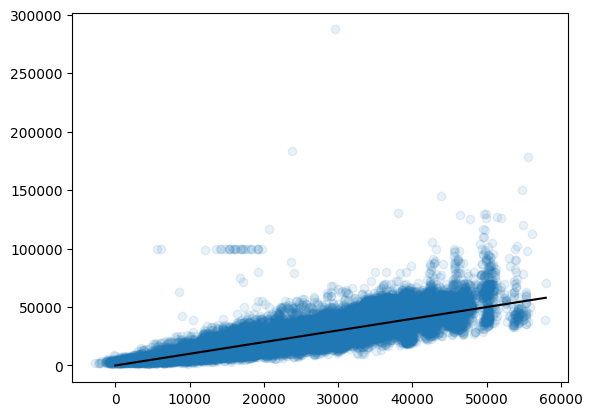

In [16]:
plt.scatter(x=pred, y=y_test, alpha = 0.1)
plt.plot([0, max(pred)],[0, max(pred)], c='black')
plt.show()

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_SGR.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="r2",
    train_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 12000, 15000, 20000, 30000, 40000, 50000])

/home/jerome/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/jerome/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/jerome/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/jerome/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before

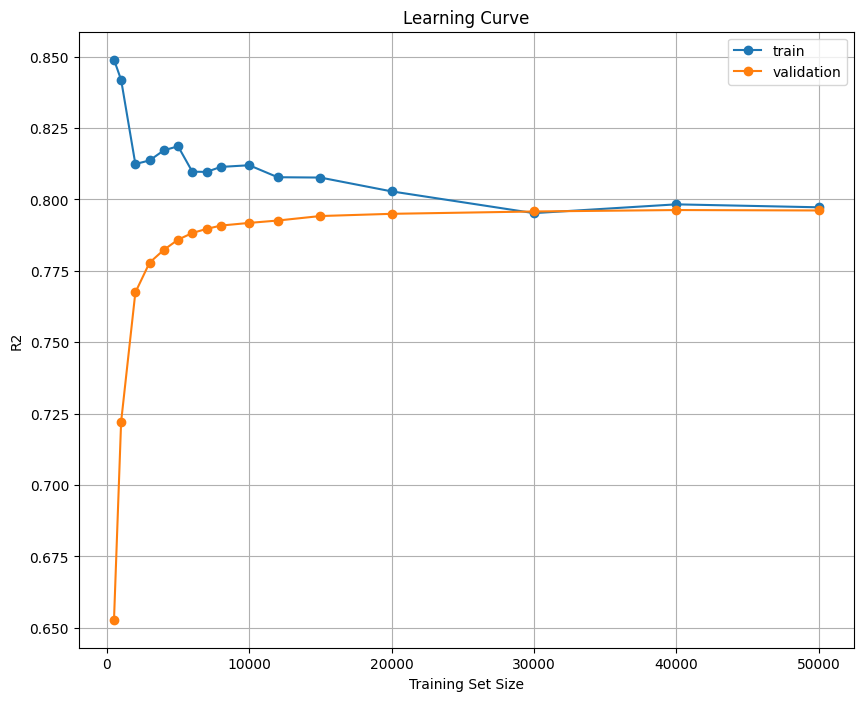

In [19]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [22]:
pickle.dump(grid_SGR.best_estimator_, open('grid_SGR.pkl', 'wb'))

<h1>Learning curve Ridge</h1>

In [23]:
param = {'alpha' : [i/100 for i in range(1, 500, 10)]}
grid_ridge = GridSearchCV(Ridge(), param, cv = 5, pre_dispatch = 5).fit(X_train, y_train)
grid_ridge.best_estimator_.score(X_test, y_test)

0.8366783695121902

In [24]:
grid_ridge.best_params_

{'alpha': 0.01}

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_ridge.best_estimator_,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="r2",
    train_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 12000, 15000, 20000, 30000, 40000, 50000])

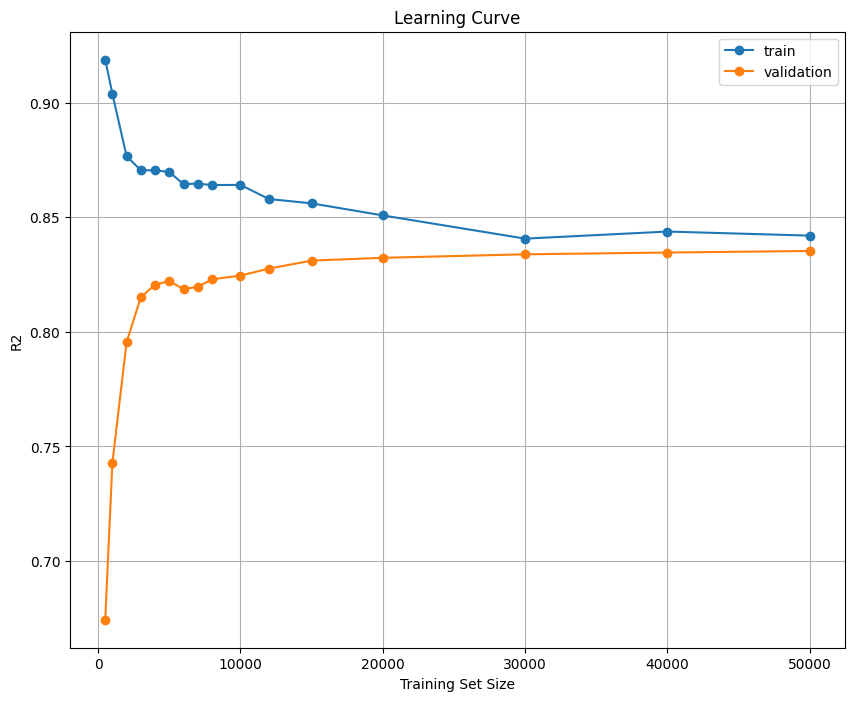

In [26]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
pred = grid_ridge.best_estimator_.predict(X_test)

In [ ]:
plt.scatter(x=pred, y=y_test, alpha = 0.1)
plt.plot([0, max(pred)],[0, max(pred)], c='black')
plt.show()

In [ ]:
X = patsify_F1.transform(X)

In [ ]:
ridge = Ridge(alpha = 3.71).fit(X, y)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid_ridge.best_estimator_,
    X=X,
    y=y,
    cv=5,
    scoring="r2",
    train_sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 12000, 15000, 20000, 30000, 40000, 50000])

In [ ]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train", marker='o')
plt.plot(train_sizes, test_mean, label="validation", marker='o')

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [ ]:
pred = ridge.predict(X)

In [ ]:
plt.scatter(x=pred, y=y, alpha = 0.1)
plt.plot([0, max(pred)],[0, max(pred)], c='black')
plt.show()

<h1>GradientBoostingRegressor</h1>

In [18]:
from sklearn.ensemble import GradientBoostingRegressor